In [22]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import constants as cs
import Dates as dates 
import payoff as pf
import GBM as gbm

%reload_ext autoreload
%autoreload 2



In [23]:


def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data = getdata()

data




[*********************100%***********************]  2 of 2 completed


Ticker,LONN.SW,SIKA.SW
Date,,
2023-04-27,542.120544,237.429871
2023-04-28,546.263306,242.368103
2023-05-02,545.868835,239.800232
2023-05-03,574.079590,241.479218
2023-05-04,572.895935,242.071823
...,...,...
2024-07-24,522.599976,262.000000
2024-07-25,559.799988,258.500000
2024-07-26,581.000000,262.000000


In [24]:
def rolling_window(r: pd.DataFrame, window_len: int,  window_end: list):
   
    windows = [(end - pd.offsets.BusinessDay(n=window_len), end) for end in window_end]
    data_vectors_windows = []
    for window in windows: 
        data_in_window = r.loc[str(window[0]) : str(window[1])]
        data_vectors_windows.append(data_in_window)
    return data_vectors_windows
    


rolling_window(r = data, window_len=60, window_end = pd.bdate_range(str(cs.initial_fixing_date), str(cs.final_fixing_date)))

[Ticker         LONN.SW     SIKA.SW
 Date                              
 2023-04-27  542.120544  237.429871,
 Ticker         LONN.SW     SIKA.SW
 Date                              
 2023-04-27  542.120544  237.429871
 2023-04-28  546.263306  242.368103,
 Ticker         LONN.SW     SIKA.SW
 Date                              
 2023-04-27  542.120544  237.429871
 2023-04-28  546.263306  242.368103,
 Ticker         LONN.SW     SIKA.SW
 Date                              
 2023-04-27  542.120544  237.429871
 2023-04-28  546.263306  242.368103
 2023-05-02  545.868835  239.800232,
 Ticker         LONN.SW     SIKA.SW
 Date                              
 2023-04-27  542.120544  237.429871
 2023-04-28  546.263306  242.368103
 2023-05-02  545.868835  239.800232
 2023-05-03  574.079590  241.479218,
 Ticker         LONN.SW     SIKA.SW
 Date                              
 2023-04-27  542.120544  237.429871
 2023-04-28  546.263306  242.368103
 2023-05-02  545.868835  239.800232
 2023-05-03  574.079590

In [26]:
params_product = {
    'Denomination': 1000,
    'Coupon_Rate': (0.08 / 252) ,  # Quarterly coupon payments
}

In [27]:
Tlist = dates.num_business_days(cs.initial_fixing_date, cs.final_fixing_date)
present_value_list = []
indexlist = []

In [28]:
import warnings
warnings.filterwarnings("ignore")
date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)
date_list = pd.Series(date_list)
date_list = date_list.tail(10).tolist()



T = date_list
present_value_list = []
for fdos in T:  
    print(fdos)
    sim_T = gbm.multi_asset_gbm_n_sims(plot= False, plotasset=False, nsims=cs.n_sims, data = data, fdos=fdos)
    lonza_path = sim_T.iloc[:, ::2]
    sika_path = sim_T.iloc[:, 1::2]
    payoff_T = pf.payoff(lonza_path, sika_path, params_product, fdos)
    print(payoff_T ,"at f{fdos}")
    expected_payoff = np.mean(payoff_T)
    present_value = expected_payoff * np.exp(-(0.018)/252*(dates.num_business_days(fdos, cs.final_fixing_date)))
    present_value_list.append(present_value)



2024-07-17 00:00:00
[1015.44307473 1001.96331315 1037.99854125 1099.11403803 1023.16209774
  966.0180573  1039.33503676 1050.28446271  979.4668146  1100.
 1018.65492018 1100.         1005.64948673 1027.52918808 1014.88030921
 1100.          900.93521691 1096.09836142 1048.66453229  874.24686721
 1035.17815875  980.29788472  925.27124269 1034.5601022  1100.
  952.58416889 1090.6561412  1020.87625784  917.76618343 1100.
  929.56531622 1079.13935558  983.9576186   998.2488206   941.30750039
 1078.09208423  964.82897212 1100.          943.79669176 1061.51010968
 1100.         1020.62445104 1100.          978.46607831 1055.77006673
 1042.32406149 1042.6064335   948.12866349  952.1511809  1061.54664737] at f{fdos}
2024-07-18 00:00:00
[ 963.02652246 1100.         1043.14420699 1019.11568745  977.23686074
 1040.57601963  885.58774173 1041.66599124 1100.          999.66987118
 1010.27233586 1030.79890742  893.12631452 1071.91454071 1051.44349531
 1100.         1021.23282893 1100.         1083.1

<Axes: >

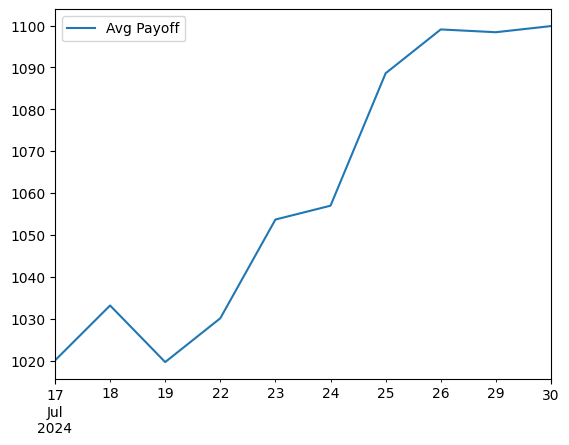

In [29]:
present_value_df = pd.DataFrame({'Avg Payoff': present_value_list}, index=T)
present_value_df.plot()

# Variance Reduction 
## Control Variate 

In [ ]:
import VarianceRedFunc as vr

S1_t = lonza_path